In [152]:
from tqdm.auto import tqdm
import torch 
import transformers
from transformers import PreTrainedTokenizer
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaForTokenClassification
#from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses, util
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
#import matplotlib.pyplot as plt 
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, PreTrainedTokenizerFast, RobertaTokenizerFast
#from torch.nn import CosineEmbeddingLoss
import random
#from torch.nn import CosineEmbeddingLoss
from torch import nn
#Build up to SBERT model 

In [153]:
import seaborn as sns
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [154]:
#df = pd.read_csv("/shared/3/projects/benlitterer/podcastData/hostIdentification/itunesGTsubset.tsv", sep="\t") 

In [157]:
trainDf.columns

Index(['Unnamed: 0', 'potentialOutPath', 'epTitle', 'left', 'ent', 'tag',
       'right', 'rssUrl', 'cleanDates', 'first500', '500ent', '500start',
       '500end', '500type', 'itunesAuthor', 'levenshtein', 'groundTruth'],
      dtype='object')

In [156]:
trainDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/hostIdentification/trainTestVal2_5/500trainLabelled.csv")
trainDf = trainDf.dropna(subset=["tag"])
trainDf["groundTruth"] = trainDf["tag"] == "HOST"
trainDf["groundTruth"] = trainDf["groundTruth"].astype(int)

valDf = pd.read_csv("/shared/3/projects/benlitterer/podcastData/hostIdentification/trainTestVal2_5/500valLabelled.csv")
valDf = valDf.dropna(subset=["tag"])
valDf["groundTruth"] = valDf["tag"] == "HOST"
valDf["groundTruth"] = valDf["groundTruth"].astype(int)

trainDf["snippetStart"] = trainDf.apply(lambda x: x["entSnippets"].lower().find(x["ent"].lower()), axis=1)
valDf["snippetStart"] = valDf.apply(lambda x: x["entSnippets"].lower().find(x["ent"].lower()), axis=1)

trainDf = trainDf[trainDf["snippetStart"] != -1]
valDf = valDf[valDf["snippetStart"] != -1]

trainDf["snippetEnd"] = trainDf["snippetStart"] + trainDf["500end"] - trainDf["500start"]
valDf["snippetEnd"] = valDf["snippetStart"] + valDf["500end"] - valDf["500start"]

def extractEnt(inRow): 
    return inRow["entSnippets"][inRow["snippetStart"]:inRow["snippetEnd"]]

#just for sanity checking whether our inferred start/end indices are correct 
#looks good!
trainDf["extractedEnt"] = trainDf.apply(extractEnt, axis=1)
valDf["extractedEnt"] = valDf.apply(extractEnt, axis=1)

KeyError: 'entSnippets'

In [107]:
deviceNum = 1
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")

In [108]:
TRAIN_FRAC = .7 
VALID_FRAC = .1
TEST_FRAC = .2

#put ground truth values into a list 
trainDf = trainDf[["entSnippets", "groundTruth", "snippetStart", "snippetEnd"]] 
trainDf = trainDf.reset_index(drop=True)

valDf = valDf[["entSnippets", "groundTruth", "snippetStart", "snippetEnd"]] 
valDf = valDf.reset_index(drop=True)

#get train, valid, test 
#trainDf, testDf = train_test_split(leanDf, test_size=0.3) 
#validDf, testDf = train_test_split(testDf, test_size=0.666) 

trainDataset = Dataset.from_pandas(trainDf)
validDataset = Dataset.from_pandas(valDf)
#testDataset = Datase|t.from_pandas(testDf)

In [109]:
valDf.head() 

,entSnippets,groundTruth,snippetStart,snippetEnd
0,"[""not allowed to talk about on Slack. It's lik...",0,75,87
1,['http://www.OperationCrossTraining.comFaceboo...,1,303,317
2,"['WoMed is a space to discuss, debate, and cel...",1,87,102
3,"['Yoga Magic hosted by ', 'Ashley Sondergaard'...",1,27,45
4,['and the City meets Howard Stern if he minore...,0,86,99


In [110]:
#TODO: figure out by tokenizer isn't padding out to max_length 

In [111]:
# Preprocessing
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length=512, padding="max_length", truncation=True)

In [112]:
# define a function that will tokenize the model, and will return the relevant inputs for the model
def tokenization(batched_text):
    return tokenizer(batched_text['entSnippets'], padding = "max_length", truncation=True, return_offsets_mapping=True)

trainDataset = trainDataset.map(tokenization, batched = True, batch_size = 20)
validDataset = validDataset.map(tokenization, batched = True, batch_size = 20)
#testDataset = testDataset.map(tokenization, batched = True, batch_size = 20)

Map:   0%|          | 0/298 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

In [113]:
trainDataset.set_format(type='torch', columns=["entSnippets", "groundTruth", "input_ids", "snippetStart", "snippetEnd", "attention_mask", "offset_mapping"])
validDataset.set_format(type='torch', columns=["entSnippets", "groundTruth", "input_ids", "snippetStart", "snippetEnd", "attention_mask", "offset_mapping"])

In [114]:
#we need to save the offset of our entity and then index token in the embedding output
#tokenizer("hello world how is everyone doing today", padding = "max_length", truncation=True, return_offsets_mapping=True)["offset_mapping"]

In [115]:
#sanity check 
print(trainDf.shape) 
print(valDf.shape) 
#print(testDf.shape) 
#print(leanDf.shape) 

(298, 4)
(99, 4)


In [116]:
len(trainDataset[22]["input_ids"]) 

512

In [138]:
#model stuff
model = RobertaForTokenClassification.from_pretrained('roberta-base').to(device) 

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [139]:
#peek at config
#dropout might be the only thing we really want to look into here 
#configuration 

In [140]:
BATCH_SIZE=4
EPOCHS=2

# initialize everything
# and setup a warmup for the first ~10% steps
optim = torch.optim.Adam(model.parameters(), lr=2e-6)
total_steps = int(len(trainDataset) / BATCH_SIZE)*EPOCHS
warmup_steps = int(0.05 * total_steps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=0, num_training_steps=total_steps - warmup_steps)
loss_func = torch.nn.CrossEntropyLoss()

#sanity check 
print(total_steps * BATCH_SIZE)
print(trainDf.shape) 

592
(298, 4)


In [141]:
total_steps

148

In [142]:
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
validLoader = torch.utils.data.DataLoader(validDataset, batch_size=BATCH_SIZE, shuffle=False)

In [143]:
#find the token indices which correspond to our entity 
def getTokenIndices(starts, ends, allOffsets):
    outIndices = [] 
    for i in range(0, len(starts)): 
        start = starts[i]
        end = ends[i] 
        offsets = allOffsets[i]
        
        """
        print(start) 
        print(end) 
        print(offsets[:20]) 
        """
        
        currIndices = []
        for j, offset in enumerate(offsets): 
            offsetL, offsetR = offset
            if offsetL >= start: 
                currIndices.append(j)
        
        #we can modify this code as need be 
        outIndices.append(min(currIndices)) 
        
    return outIndices

In [144]:
"""
debugging getTokenIndices
#where are we supposed to start 
print(outIndices[2])

#check check the offsets for the index we're supposed to use 
print(batch["offset_mapping"][2][6])
print(batch["entSnippets"][2][17:21])

#looks good from checking examples 
"""

'\ndebugging getTokenIndices\n#where are we supposed to start \nprint(outIndices[2])\n\n#check check the offsets for the index we\'re supposed to use \nprint(batch["offset_mapping"][2][6])\nprint(batch["entSnippets"][2][17:21])\n\n#looks good from checking examples \n'

In [145]:
#validation function 
def validate(model, validLoader, loss_func):
    model.eval()
    
    outList = [[], []]
    for batch in tqdm(validLoader): 
        
        optim.zero_grad()
        
        input_ids = batch["input_ids"].to(device) 
        attention_mask = batch["attention_mask"].to(device) 
        output = model(input_ids, attention_mask=attention_mask)

        #get the index/indices of our tokens that correspond to the entitiy we want to classify 
        outIndices = getTokenIndices(batch["snippetStart"], batch["snippetEnd"], batch["offset_mapping"]) 

        #get the output logits only for the indices we care about
        #i.e. where there's a named entity we seek to classify 
        tokenLogits = []
        for i, logit in enumerate(output.logits): 
            index = outIndices[i]
            #print(logic[index])  
            #print(logit.shape)
            tokenLogits.append(logit[index,:])

        #run logits through softmax to normalize probabilities 
        tokenLogits = torch.stack(tokenLogits)
        normedOutputs = nn.functional.softmax(tokenLogits, 1) 
        
        #get class predictions 
        preds = normedOutputs.argmax(dim=1)
        
        #get groundtruth and compute loss 
        gt = batch["groundTruth"].to(device)
        loss = loss_func(normedOutputs, gt)
        
        outList[0] += preds.detach().cpu().tolist()
        outList[1] += gt.detach().cpu().tolist() 
        
    print(outList[0][:10]) 
    print(outList[1][:10])
    print(sum([item == 0 for item in outList[0]]))
    print(sum([item == 1 for item in outList[0]]))
    f1 = f1_score(outList[0], outList[1]) 
    print(f1)
    model.train()
    return f1

In [146]:
lossList = []
validateList = []
for epoch in range(EPOCHS):
    print("EPOCH: " + str(epoch))
    #validateBi(model, validLoader, loss_func)
    
    model.train()  # make sure model is in training mode

    #DEBUGGING
    i = 0 
    currLossList = []
    for batch in tqdm(trainLoader):
        optim.zero_grad()
        
        input_ids = batch["input_ids"].to(device) 
        attention_mask = batch["attention_mask"].to(device) 
        output = model(input_ids, attention_mask=attention_mask)

        #get the index/indices of our tokens that correspond to the entitiy we want to classify 
        outIndices = getTokenIndices(batch["snippetStart"], batch["snippetEnd"], batch["offset_mapping"]) 

        #get the output logits only for the indices we care about
        #i.e. where there's a named entity we seek to classify 
        tokenLogits = []
        for j, logit in enumerate(output.logits): 
            index = outIndices[j]
            #print(logic[index])  
            #print(logit.shape)
            tokenLogits.append(logit[index,:])

        #run logits through softmax to normalize probabilities 
        tokenLogits = torch.stack(tokenLogits)
        normedOutputs = nn.functional.softmax(tokenLogits, 1) 
        preds = normedOutputs.argmax(dim=1)
        
        #get groundtruth and compute loss 
        gt = batch["groundTruth"].to(device)
        loss = loss_func(normedOutputs, gt)
        
        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        scheduler.step()
        
        if i % 10 == 0: 
            #for train loss
            curLossList = []
            lossList.append([i, np.mean(currLossList)])
            
            #for validation stuff
            validateList.append([i, validate(model, validLoader, loss_func)]) 
            model.train() 
            print(scheduler.get_lr()) 
            
        currLossList.append(loss.item()) 
        i += 1
        
        #DEBUGGING
        """
        print(loss)
        print(scheduler.get_last_lr())
        
        #see if model params have changed
        param = list(model.parameters())[0].clone()
        print(torch.equal(param.data, prevParam.data))
        """


EPOCH: 0


  0%|          | 0/75 [00:00<?, ?it/s]

/opt/anaconda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/25 [00:00<?, ?it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
98
1
0.0
[1.9858156028368793e-06]


  0%|          | 0/25 [00:00<?, ?it/s]

[0, 0, 1, 1, 0, 0, 0, 1, 0, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
71
28
0.4150943396226415
[1.8439716312056737e-06]


  0%|          | 0/25 [00:00<?, ?it/s]

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
21
78
0.8461538461538461
[1.702127659574468e-06]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
4
95
0.8670520231213873
[1.5602836879432624e-06]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
1
98
0.8863636363636364
[1.4184397163120568e-06]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[1.276595744680851e-06]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[1.1347517730496454e-06]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[9.929078014184397e-07]
EPOCH: 1


  0%|          | 0/75 [00:00<?, ?it/s]

/opt/anaconda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[9.219858156028369e-07]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[7.801418439716312e-07]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[6.382978723404255e-07]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[4.964539007092198e-07]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[3.546099290780142e-07]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[2.127659574468085e-07]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[7.092198581560284e-08]


  0%|          | 0/25 [00:00<?, ?it/s]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 0, 1, 0, 1, 1, 0]
0
99
0.8813559322033898
[0.0]


In [147]:
lossDf = pd.DataFrame(lossList, columns=["iter", "loss"]).dropna()

In [148]:
validDf = pd.DataFrame(validateList, columns=["iter", "f1"]) 

In [149]:
resultsDf = pd.merge(lossDf, validDf, on="iter", how="inner") 

In [150]:
lossDf

,iter,loss
1,10,0.724935
2,20,0.706570
3,30,0.696273
4,40,0.687096
5,50,0.682225
6,60,0.675875
7,70,0.665048
9,10,0.627107
10,20,0.639550
11,30,0.633054


Text(0.5, 0.98, 'Predicting Hosts in Transcript Snippets Surrounding Named Entities')

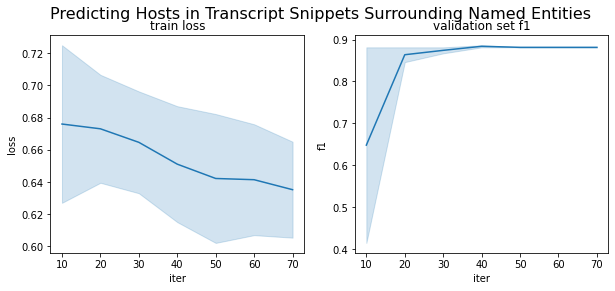

In [151]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 
sns.lineplot(data=resultsDf, x="iter", y="loss", ax=axs[0])
sns.lineplot(data=resultsDf, x="iter", y="f1", ax=axs[1])
axs[0].set_title("train loss") 
axs[1].set_title("validation set f1") 
fig.suptitle("Predicting Hosts in Transcript Snippets Surrounding Named Entities", size=16) 

In [152]:
model = model.to(device) 

In [166]:
output = model(input_ids, attention_mask=attention_masks)
normedOutputs = nn.functional.softmax(output.logits) 
preds = normedOutputs.argmax(dim=1) 

<ipython-input-166-2fd2f66a40ba>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  normedOutputs = nn.functional.softmax(output.logits)
